In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
import warnings
 
warnings.filterwarnings("ignore")
plt.rc('font', family='NanumBarunGothic')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
ska =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SK/ska.csv', index_col='Unnamed: 0',parse_dates=['STD_YMD'])
scr =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/CARD_SPENDING_RESIDENT.txt', sep='\t',parse_dates = ['STD_DD'])
scf =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/CARD_SPENDING_FOREIGNER.txt', sep='\t',parse_dates = ['STD_DD'], encoding='cp949')

dong = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/전체동별클러스터링.csv', sep = ',', encoding='utf-8')
dong_cd = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/SC동코드변환.csv', sep = ',', encoding='utf-8')

In [ ]:
# 신한카드 내국인 전처리

# 코드 -> 이름으로 바꾸는 함수 : name_a_to_b
def name_a_to_b(data,col,a,b):
  data = data.replace({col:a}, {col:b}, inplace=True)
  return(data)

# 카테고리 코드 -> 이름
cat_code = [10,20,21,22,30,31,32,33,34,35,40,42,43,44,50,52,60,62,70,71,80,81,92]
cat_name = ['숙박','레저용품','레저업소','문화취미','가구','전기','주방용구',
            '연료판매','광학제품','가전','유통업','의복','직물','신변잡화','서적문구','사무통신',
            '자동차판매','자동차정비','의료기관','보건위생','요식업소','음료식품','수리서비스']
for i in range(len(cat_code)):
  name_a_to_b(scr,'MCT_CAT_CD',cat_code[i],cat_name[i])

# 시구 및 동 이름 추가
scr = pd.merge(scr, dong_cd, left_on=['GU_CD', 'DONG_CD'], right_on=['GU_CD', 'HDONG_CD'])

# 날짜 형식으로 변환(int->str->date)
scr['STD_YMD'] = pd.to_datetime(scr['STD_DD'].astype(str), format='%Y%m%d',infer_datetime_format=True)

# 클러스터링 추가
scr = pd.merge(scr, dong, left_on='HDONG_NM', right_on='HDONG_NM')

# 연도 추가
scr['STD_Y'] = scr['STD_DD'].astype(str).str.slice(0,4)

scr = scr.drop(['STD_DD', 'GU_CD', 'DONG_CD', 'HDONG_CD', 'AGE_CD'], axis=1)

In [ ]:
# 신한카드 외국인 전처리

for i in range(len(cat_code)):
  name_a_to_b(scf,'MCT_CAT_CD', cat_code[i], cat_name[i])

# 시구 및 동 이름 추가
scf = pd.merge(scf, dong_cd, left_on=['GU_CD', 'DONG_CD'], right_on=['GU_CD', 'HDONG_CD'])

# 날짜 형식으로 변환(int->str->date)
scf['STD_YMD'] = pd.to_datetime(scf['STD_DD'].astype(str), format='%Y%m%d',infer_datetime_format=True)

# 클러스터링 추가
scf = pd.merge(scf, dong, left_on='HDONG_NM', right_on='HDONG_NM')

# 연도 추가
scf['STD_Y'] = scf['STD_DD'].astype(str).str.slice(0,4)

scf = scf.drop(['STD_DD', 'GU_CD', 'DONG_CD', 'HDONG_CD'], axis=1)

In [ ]:
scr = scr.query('SIDO_NM == "서울"')
scf = scf.query('SIDO_NM == "대구"')

scr20 = scr[scr['STD_YMD'] > '2020']
scf20 = scf[scf['STD_YMD'] > '2020']

In [ ]:
ska = pd.merge(ska, dong_cd, left_on=['HDONG_NM'], right_on=['HDONG_NM']).drop(['HDONG_CD_y'], axis=1)
ska = ska.query('GU_NM == "서울 중구" | GU_NM == "서울 노원구"')

In [ ]:
ska['유동인구'] = ska.iloc[:,4:34].sum(axis=1)
ska = ska.iloc[:,[1,3,36]]
ska20 = ska[ska['STD_YMD'] > '2020']
ska20 = ska20.groupby(['STD_YMD']).agg(np.sum)

In [ ]:
scr20 = scr20.groupby(['STD_YMD', 'MCT_CAT_CD']).agg(np.sum).unstack(level=1).fillna(0)
scf20 = scf20.groupby(['STD_YMD', 'MCT_CAT_CD']).agg(np.sum).unstack(level=1).fillna(0)

In [ ]:
scr20cnt = scr20.droplevel(axis=1, level=0).iloc[:,0:23]
scr20amt = scr20.droplevel(axis=1, level=0).iloc[:,23:]

scf20cnt = scf20.droplevel(axis=1, level=0).iloc[:,0:23]
scf20amt = scf20.droplevel(axis=1, level=0).iloc[:,23:]

In [ ]:
# 그림을 먼저 확인
# scr 이랑 굵은 ska scr20cnt & ska20
import plotly.express as px
import plotly.graph_objects as go

def plott(data):
    fig = go.Figure()
    title = '2020 일자별 SK 유동인구 & SC 유통'
    labels = ['유동인구', '가구', '가전', '광학제품', '레저업소', '레저용품', '문화취미', '보건위생', '사무통신', '서적문구', '수리서비스', '숙박', '신변잡화', '연료판매', '요식업소', '유통업', '음료식품', '의료기관', '의복', '자동차정비', '자동차판매', '전기', '주방용구', '직물']
    # colors = ['rgb(49,130,189)','rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(189,189,189)' ,'rgb(150,150,150)']
    
    mode_size = [12]+[8]*22
    line_size = [4]+[2]*22
    
    for i in range(0, 23):
        fig.add_trace(go.Scatter(x=data.index, y=data.iloc[:,i], mode='lines', name=labels[i], line=dict(width=line_size[i]), connectgaps=True)) # color=colors[i],
        fig.update_layout(
            autosize=False,
            width=1200,
            height=800,
            margin=dict(
                l=50,
                r=50,
                b=100,
                t=100,
                pad=4))
    fig.show()

plott(pd.concat([ska20, scr20cnt], axis=1))

# **1. 모든 업종 VS 유동인구 상관관계 (2020)**

In [ ]:
corr_sp = []
for i in range(24):
  corr_sp.append(pd.concat([ska20, scr20cnt], axis=1).iloc[:,[0,i+0]].corr(method='spearman').iloc[0,1])

corr_p = []
for i in range(24):
  corr_p.append(pd.concat([ska20, scr20cnt], axis=1).iloc[:,[0,i+0]].corr(method='pearson').iloc[0,1])

In [ ]:
corr_sp = pd.DataFrame(corr_sp,
                    index = ['유동인구', '가구', '가전', '광학제품', '레저업소', '레저용품', '문화취미', '보건위생', '사무통신', '서적문구', '수리서비스', '숙박', '신변잡화', '연료판매', '요식업소', '유통업', '음료식품', '의료기관', '의복', '자동차정비', '자동차판매', '전기', '주방용구', '직물'],
                    columns = ['spearman corr'])
corr_p = pd.DataFrame(corr_p,
                    index = ['유동인구', '가구', '가전', '광학제품', '레저업소', '레저용품', '문화취미', '보건위생', '사무통신', '서적문구', '수리서비스', '숙박', '신변잡화', '연료판매', '요식업소', '유통업', '음료식품', '의료기관', '의복', '자동차정비', '자동차판매', '전기', '주방용구', '직물'],
                    columns = ['pearson corr'])

corr1 = pd.concat([corr_sp, corr_p], axis=1)
# corr1.sort_values('pearson corr', ascending=False)

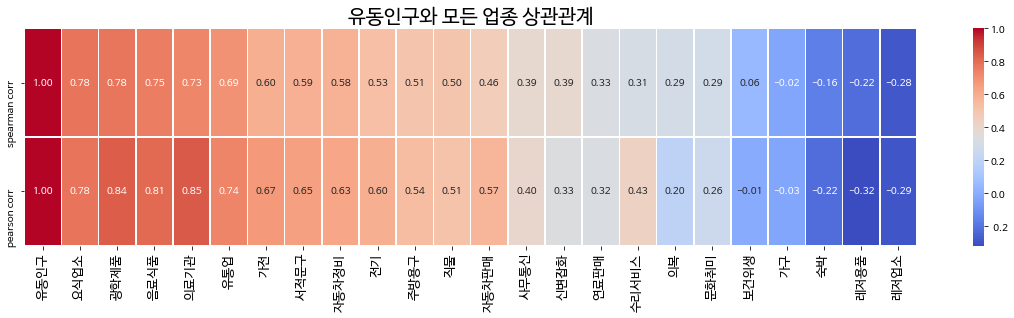

In [ ]:
plt.figure(figsize=(20,4))
sns.heatmap(data = corr1.sort_values('spearman corr', ascending=False).T, annot=True, fmt = '.2f', linewidths=0.5, cmap='coolwarm')
plt.title('유동인구와 모든 업종 상관관계', fontsize=20)
plt.tick_params(axis="x", labelsize=13)
plt.show()

# **2. 클러스터3 업종 VS 유동인구 상관관계 (2020)**

In [ ]:
corr2 = corr1.query('index in ["유통업", "서적문구", "전기", "사무통신", "문화취미", "레저업소", "숙박"]')

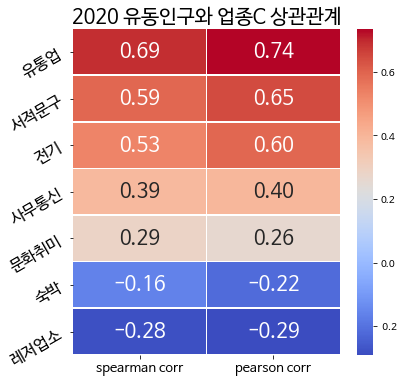

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(data = corr2.sort_values('spearman corr', ascending=False), annot=True, annot_kws={"size": 20}, fmt = '.2f', linewidths=0.5, cmap='coolwarm') # .T
plt.title('2020 유동인구와 업종C 상관관계', fontsize=20)
plt.yticks(rotation=30)
plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=16)
plt.show()

# **3. 모든 업종 VS 유동인구 상관관계 (2020 주별)**

In [ ]:
all20cnt = pd.concat([ska20, scr20cnt], axis=1)

In [ ]:
all20cnt = all20cnt.resample('W-Fri').sum()
all20cnt.drop(all20cnt.tail(1).index,inplace=True) # 막주 삭제

In [ ]:
all20cnt.head()

,유동인구,가구,가전,광학제품,레저업소,레저용품,문화취미,보건위생,사무통신,서적문구,수리서비스,숙박,신변잡화,연료판매,요식업소,유통업,음료식품,의료기관,의복,자동차정비,자동차판매,전기,주방용구,직물
STD_YMD,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-07,19714531.32,415.0,3820.0,3563.0,123211.0,39752.0,19099.0,69150.0,86198.0,38949.0,7667.0,18790.0,9609.0,63297.0,2422550.0,1737523.0,183289.0,346393.0,22741.0,45965.0,391.0,204.0,1989.0,1309.0
2020-02-14,19993640.72,400.0,3656.0,3723.0,131612.0,45565.0,22500.0,75183.0,92152.0,40442.0,7536.0,18788.0,11147.0,64090.0,2555561.0,1808080.0,189373.0,322235.0,25488.0,46537.0,411.0,231.0,2516.0,1236.0
2020-02-21,19875139.85,425.0,3584.0,4117.0,127361.0,44079.0,23456.0,75646.0,99190.0,38409.0,7936.0,20040.0,11429.0,64151.0,2507803.0,1822937.0,187099.0,318712.0,25438.0,48172.0,380.0,187.0,2624.0,1362.0
2020-02-28,17241220.96,361.0,3260.0,3233.0,106349.0,28733.0,14538.0,57635.0,78790.0,29717.0,7267.0,17169.0,8774.0,58250.0,2122173.0,1708887.0,188198.0,322851.0,15998.0,39724.0,268.0,179.0,1872.0,993.0
2020-03-06,16374483.09,420.0,3699.0,3246.0,100011.0,28098.0,13614.0,57225.0,79867.0,33551.0,8258.0,13397.0,8991.0,58033.0,2115778.0,1658140.0,191783.0,300833.0,16206.0,38214.0,591.0,260.0,1898.0,1076.0


In [ ]:
corr_sp = []
for i in range(24):
  corr_sp.append(all20cnt.iloc[:,[0,i+0]].corr(method='spearman').iloc[0,1])

corr_p = []
for i in range(24):
  corr_p.append(all20cnt.iloc[:,[0,i+0]].corr(method='pearson').iloc[0,1])

In [ ]:
corr_sp = pd.DataFrame(corr_sp,
                    index = ['유동인구', '가구', '가전', '광학제품', '레저업소', '레저용품', '문화취미', '보건위생', '사무통신', '서적문구', '수리서비스', '숙박', '신변잡화', '연료판매', '요식업소', '유통업', '음료식품', '의료기관', '의복', '자동차정비', '자동차판매', '전기', '주방용구', '직물'],
                    columns = ['spearman corr'])
corr_p = pd.DataFrame(corr_p,
                    index = ['유동인구', '가구', '가전', '광학제품', '레저업소', '레저용품', '문화취미', '보건위생', '사무통신', '서적문구', '수리서비스', '숙박', '신변잡화', '연료판매', '요식업소', '유통업', '음료식품', '의료기관', '의복', '자동차정비', '자동차판매', '전기', '주방용구', '직물'],
                    columns = ['pearson corr'])

corr3 = pd.concat([corr_sp, corr_p], axis=1)
# corr1.sort_values('pearson corr', ascending=False)

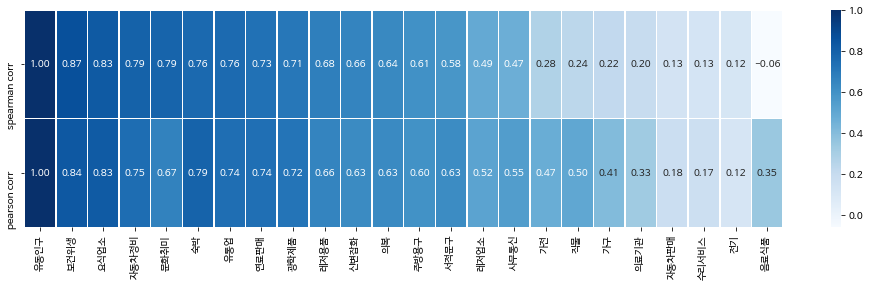

In [ ]:
plt.figure(figsize=(17,4))
sns.heatmap(data = corr3.sort_values('spearman corr', ascending=False).T, annot=True, fmt = '.2f', linewidths=0.5, cmap='Blues')
plt.show()


# **4. 클러스터3 업종 VS 유동인구 상관관계(2020 주별)**

In [ ]:
corr4 = corr3.query('index in ["유동인구", "유통업", "서적문구", "전기", "사무통신", "문화취미", "레저업소", "숙박"]')

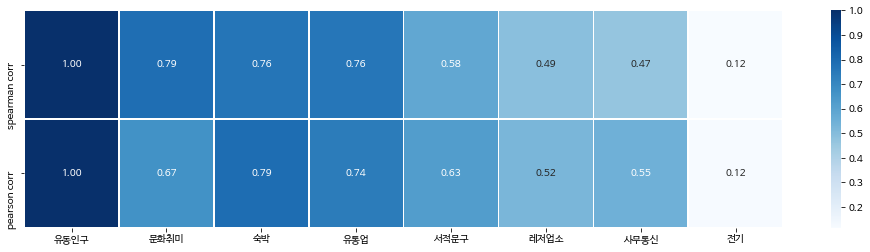

In [ ]:
plt.figure(figsize=(17,4))
sns.heatmap(data = corr4.sort_values(['spearman corr', 'pearson corr'], ascending=False).T, annot=True, fmt = '.2f', linewidths=0.5, cmap='Blues')
plt.show()

# **4. 유통업 VS 유동인구 시계열 그래프**

In [ ]:
all20cnt['유동인구_'] = all20cnt['유동인구']/10

In [ ]:
all20cnt.index = ['2-1', '2-2', '2-3', '2-4', '3-1', '3-2', '3-3', '3-4', '4-1', '4-2', '4-3', '4-4','4-5','5-1', '5-2', '5-3', '5-4']

In [ ]:
fig = plt.figure(figsize=(13,6))

plt.plot(all20cnt.index, all20cnt['유통업'], linestyle='-', marker='o', color='#2F9599', label="SC 유통업")
plt.plot(all20cnt.index, all20cnt['유동인구_'], linestyle='-', marker='o', color='#EC2049',label="SKT 유동인구")

mycolor ='grey'; min=1630000
plt.axvline(x='2-3',color=mycolor,linestyle='--')
plt.text('2-3',min,'신천지', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
plt.axvline(x='3-2',color=mycolor,linestyle='--')
plt.text('3-2',min, '마스크 5부제', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
plt.axvline(x='3-4', color=mycolor,linestyle='--')
plt.text('3-4',min, '사회적 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
plt.axvline(x='4-2', color=mycolor,linestyle='--')
plt.text('4-2', min, '고강도 사회적 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
plt.axvline(x='5-1', color=mycolor,linestyle='--')
plt.text('5-1',min,'생활속 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.legend(loc='upper center', prop={'size': 12}, ncol=6)
plt.title('2020 유동인구 - 유통업 시계열 그래프', size=20)
plt.tick_params(axis="x", labelsize=13)